In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging
import pandas as pd
import json

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)


In [2]:
from ROOT import TF1, TMultiGraph, TGraphErrors, Math, TGraphAsymmErrors

Welcome to JupyROOT 6.22/06


In [4]:
from ipynb.fs.full.functions import *
from ipynb.fs.defs.comparing import plot_gsf_OMPy_vs_OMS

In [5]:
om.__full_version__;
np.random.seed(1382398)

In [6]:
plt.rcParams["figure.dpi"] = 80
plt.rcParams["errorbar.capsize"] = 5
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams['font.size'] = 25
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['text.usetex'] = True

Extracting OMPy data

IndexError: index 35 is out of bounds for axis 0 with size 35

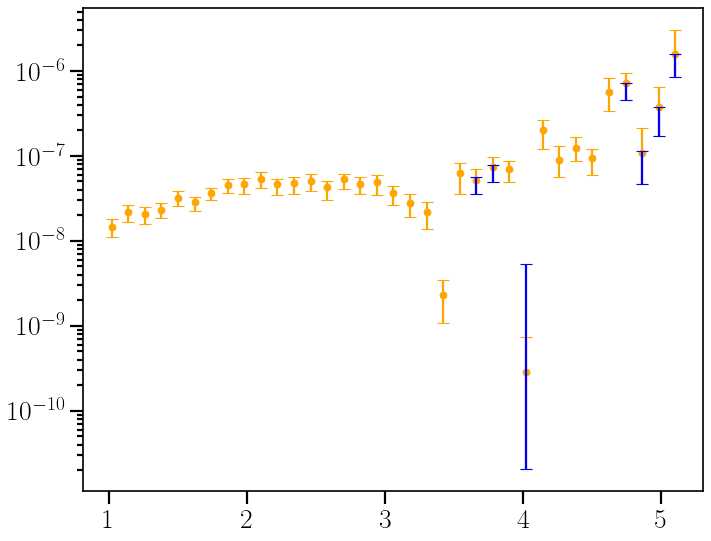

In [8]:
#gsf_values = read_OMPy('02-08_09:57:20')[0]
gsf_values = read_OMPy('02-23_13:03:23')[0]
energy_gsf_ompy = np.asarray(gsf_values[0])
gsf_ompy_median = np.asarray(gsf_values[1])
gsf_ompy_error = np.asarray(gsf_values[4])


fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='orange')
ax.set_yscale('log')
deletes=[22, 23, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39]
for i in deletes:
    err=[[gsf_ompy_error[0][i]],[gsf_ompy_error[1][1]]]
    ax.errorbar(x=energy_gsf_ompy[i], y=gsf_ompy_median[i], yerr=err, color='blue', zorder=4)


energy_gsf_ompy = np.delete(energy_gsf_ompy, deletes)
gsf_ompy_median = np.delete(gsf_ompy_median, deletes)
gsf_ompy_error_0 = np.delete(gsf_ompy_error[0], deletes)
gsf_ompy_error_1 = np.delete(gsf_ompy_error[1], deletes)
gsf_ompy_error = [gsf_ompy_error_0, gsf_ompy_error_1]

fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, fmt='o', color='orange')
ax.set_yscale('log')

In [9]:
with open('plotting/exfor_data/u233_g_x.json') as K:
    data_U233 = json.load(K)
datasets_U233=data_U233["datasets"]

energy_exp1, gsf_exp1, gsf_exp1_error =  extract_JSON(datasets_U233[0]['data'], 5, 0, 1)
gsf_exp1 = cs_to_gsf(energy_exp1, gsf_exp1)
gsf_exp1_error = cs_to_gsf(energy_exp1, gsf_exp1_error)


In [10]:
#some root fitting initializer
Math.MinimizerOptions.SetDefaultMaxFunctionCalls(10000)
#Kopecky data
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])
fE = TGraphErrors(1,fEene,fEx,fEeneerr,fEerr)
fM = TGraphErrors(1,fMene,fMx,fEeneerr,fMerr)

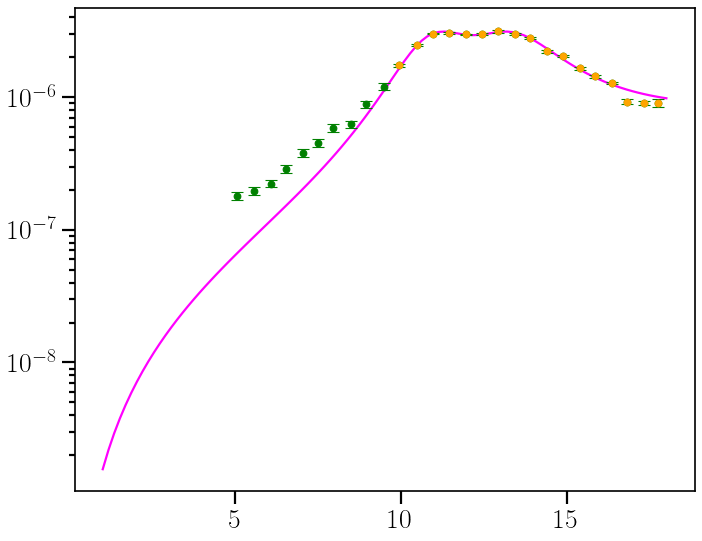

 FCN=78.8913 FROM HESSE     STATUS=OK             50 CALLS         375 TOTAL
                     EDM=3.11393e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Gamma_GLo1   3.00263e+00   1.50549e-01   1.26552e-04   2.40957e-03
   2  E_GLo1       1.13334e+01   5.80845e-02   6.97145e-05   2.11942e-03
   3  sigma_GLo1   3.05361e+02   9.02629e+00   8.98628e-03   3.91099e-05
   4  Gamma_GLo2   3.50471e+00   1.44219e-01   2.98932e-05   2.03963e-02
   5  E_GLo2       1.37140e+01   4.28895e-02   7.97170e-05  -1.01906e-03
   6  sigma_GLo2   3.15135e+02   1.20384e+01   1.19742e-02   1.98770e-05
   7  T_f          2.00000e-02   7.61620e-03   7.51891e-02  -6.91287e-06


In [11]:
#Define parameters & start values for the GLO
E_r_GLo1 = 11.4 # centroid (MeV)
Gamma_r_GLo1 = 2.0 # width (MeV)
sigma_r_GLo1 = 300 # peak cross section (mb)
E_r_GLo2 = 14.0 # centroid (MeV)
Gamma_r_GLo2 = 4.3 # width (MeV)
sigma_r_GLo2 = 480 # peak cross section (mb)
T_f    = 0.015 #constant temperature of final states (MeV)

parameter_array_E1 = np.asarray([Gamma_r_GLo1, E_r_GLo1, sigma_r_GLo1, 
                                 Gamma_r_GLo2, E_r_GLo2, sigma_r_GLo2, T_f])

#TGrapgErrors of Berman-data
energy_exp1_error = np.zeros(len(energy_exp1))
berman_233_gdrexp = TGraphErrors(len(energy_exp1), energy_exp1, gsf_exp1, energy_exp1_error, gsf_exp1_error)

#Defining GDR Data
GDR_data = TMultiGraph()
GDR_data.Add(berman_233_gdrexp, "P")

#Making TGraphErrors of reduced Berman-data
gsf_exp1_reduced = gsf_exp1[10:]
gsf_exp1_error_reduced = gsf_exp1_error[10:]
energy_exp1_reduced = energy_exp1[10:]
energy_exp1_error_reduced = np.zeros(len(energy_exp1_reduced))

berman_233_gdrexp_reduced = TGraphErrors(len(energy_exp1_reduced), np.asarray(energy_exp1_reduced), 
                                np.asarray(gsf_exp1_reduced), np.asarray(energy_exp1_error_reduced), 
                                np.asarray(gsf_exp1_error_reduced))

#Fit of the GLO model for the GDR part
xmin_GDR = 1
xmax_GDR = 18
no_of_parameters_GDR = 7
fit_strength_E1 = TF1('fit_strength_E1', FitFunctionE1, xmin_GDR, xmax_GDR, no_of_parameters_GDR)
fit_strength_E1.SetParameters(parameter_array_E1)

#setting limits
fit_strength_E1.SetParLimits(6, 0.01, 0.02) #parameter #6 = T_f
fit_strength_E1.SetParLimits(3, 0.1, 10.) #parameter #3 = Gamma_r_GLo2
fit_strength_E1.SetParNames('Gamma_GLo1', 'E_GLo1', 'sigma_GLo1',
                        'Gamma_GLo2', 'E_GLo2', 'sigma_GLo2', 'T_f')


#defining and fitting reduced GDR Data
GDR_reduced_data = TMultiGraph()
GDR_reduced_data.Add(berman_233_gdrexp_reduced, "P")
GDR_reduced_data.Fit(fit_strength_E1, 'RM+')
#GDR_data.Fit(fit_strength_E1, 'RM+')

#Plotting fit of GDR
fitted_parameters_E1 = np.zeros(no_of_parameters_GDR)
for i in range(no_of_parameters_GDR):
    fitted_parameters_E1[i] = fit_strength_E1.GetParameters()[i]
x_plot_E1 = [np.linspace(xmin_GDR, xmax_GDR, 100)]
x_plot_E1 = [np.linspace(1, 18, 100)]
y_plot_E1 = FitFunctionE1(x_plot_E1, fitted_parameters_E1)

fig, ax = plt.subplots()

ax.plot(x_plot_E1[0], y_plot_E1, color='magenta', label='E1 GLo')

#Experimental: Berman 1986
ax.errorbar(energy_exp1, gsf_exp1, yerr=gsf_exp1_error, x_err=None, fmt="o", color='green', label="$U^{234}(\gamma,n)$ Berman (1986)")
ax.errorbar(energy_exp1_reduced, gsf_exp1_reduced, xerr=None, yerr=None, fmt='o', color='orange')
ax.set_yscale('log')
fig.show()

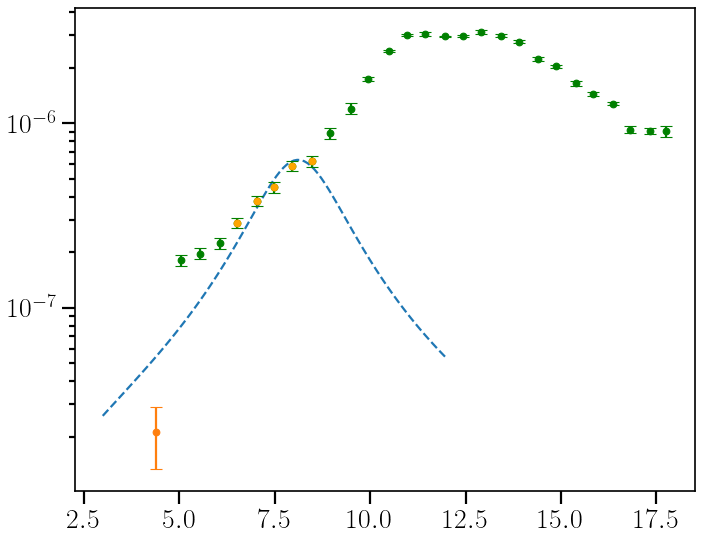

 FCN=34.6148 FROM HESSE     STATUS=OK             16 CALLS         114 TOTAL
                     EDM=3.28487e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Gamma_pyg2   2.39954e+00   1.53409e-01   1.17828e-05   2.90181e-03
   2  E_pyg2       8.20423e+00   8.53679e-02   2.52187e-05  -3.87939e-03
   3  sigma_pyg2   5.96781e+01   2.96978e+00   1.04512e-03   1.49799e-05


In [12]:
#START VALUES pygmy 2/spinflip resonance
E_pyg2 = 7.0 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_pyg2 = 1.5 #Width (MeV)
sigma_pyg2 = 20.0 #peak cross section (mb)

parameter_array_M1 = np.asarray([Gamma_pyg2, E_pyg2, sigma_pyg2])

xmin_pyg2 = 3.
xmax_pyg2 = 12.
no_of_parameters_pyg2 = 3
fit_strength_M1 = TF1('fit_strength_M1', FitPygmy, xmin_pyg2, xmax_pyg2, no_of_parameters_pyg2)
fit_strength_M1.SetParameters(parameter_array_M1)
fit_strength_M1.SetParLimits(0, 0.1, 10.) #to remain positive/physical
fit_strength_M1.SetParNames('Gamma_pyg2', 'E_pyg2', 'sigma_pyg2')

#Kopecky data
fEx = np.asarray([12.14E-08])
fEerr = np.asarray([3.92E-08])
fEene = np.asarray([3.9])
fEeneerr = np.asarray([0.00])
fMx = np.asarray([2.11E-08])
fMerr = np.asarray([0.78E-08])
fMene = np.asarray([4.4])
fMeneerr = np.asarray([0.0])
fE = TGraphErrors(1,fEene,fEx,fEeneerr,fEerr)
fM = TGraphErrors(1,fMene,fMx,fEeneerr,fMerr)

#Making TGraphErrors of reduced Berman-data
gsf_exp1_reduced = gsf_exp1[3:8]
gsf_exp1_error_reduced = gsf_exp1_error[3:8]
energy_exp1_reduced = energy_exp1[3:8]
energy_exp1_error_reduced = np.zeros(len(energy_exp1_reduced))

berman_233_gdrexp_reduced = TGraphErrors(len(energy_exp1_reduced), np.asarray(energy_exp1_reduced), 
                                np.asarray(gsf_exp1_reduced), np.asarray(energy_exp1_error_reduced), 
                                np.asarray(gsf_exp1_error_reduced))


#fitting to M1 data
M1_data = TMultiGraph()
M1_data.Add(fM)
M1_data.Add(berman_233_gdrexp_reduced) #adding reduced berman data to the fit
M1_data.Fit(fit_strength_M1, 'RM+')

#prepare for plotting
fitted_parameters_pyg2 = np.zeros(no_of_parameters_pyg2)
fitted_parameters_pyg2[0] = fit_strength_M1.GetParameter(0)
fitted_parameters_pyg2[1] = fit_strength_M1.GetParameter(1)
fitted_parameters_pyg2[2] = fit_strength_M1.GetParameter(2)
x_plot_pyg2 = [np.linspace(xmin_pyg2, xmax_pyg2, 100)]
y_plot_pyg2 = FitPygmy(x_plot_pyg2, fitted_parameters_pyg2)

#plotting, together with berman data
fig, ax = plt.subplots()

ax.plot(x_plot_pyg2[0], y_plot_pyg2, '--', label='Pyg2 Resonance/M1')

ax.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='o', label="$U^{234}(n,\gamma)$ M1, Kopecky")
#Experimental: Berman 1986
ax.errorbar(energy_exp1, gsf_exp1, yerr=gsf_exp1_error, x_err=None, fmt="o", color='green', label="$U^{234}(\gamma,n)$ Berman (1986)")
ax.errorbar(energy_exp1_reduced, gsf_exp1_reduced, xerr=None, yerr=None, fmt='o', color='orange')

ax.set_yscale('log')
fig.show()

In [13]:
#TGraphErrors of OmPy data
gsf_ompy_median = np.asarray(gsf_ompy_median)
gsf_ompy_error = np.asarray(gsf_ompy_error)
energy_gsf_ompy = np.asarray(energy_gsf_ompy)
empties = np.zeros(len(gsf_ompy_median))

gsf_ompy = TGraphAsymmErrors(len(gsf_ompy_median), energy_gsf_ompy, gsf_ompy_median, empties, empties, gsf_ompy_error[0], gsf_ompy_error[1])

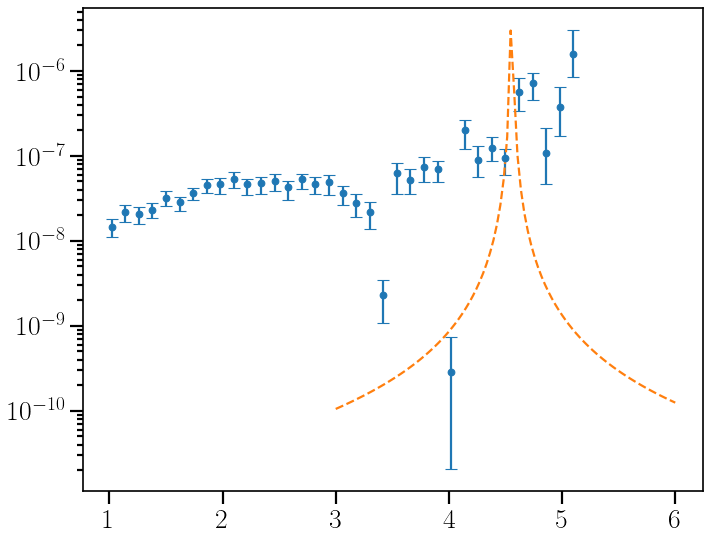

 FCN=117.001 FROM HESSE     STATUS=NOT POSDEF     16 CALLS        2622 TOTAL
                     EDM=3.89791e-07    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Gamma_pyg1   9.76196e-04   1.98279e-03   3.20243e-08  -3.92846e+00
   2  E_pyg1       4.55485e+00   3.10993e-02   3.15835e-06   3.31856e-02
   3  sigma_pyg1   5.83883e+04   2.37107e+05   1.16840e+00  -3.54359e-08


In [14]:




#START VALUES pygmy resonance 1
E_pyg1 = 4.5 # Pygmy centroid (MeV)
Gamma_pyg1 = 0.4 # Width (MeV)
sigma_pyg1 = 5.0 #peak cross section (mb)

#defining  reduced OmPy Data
OMPy_data = TMultiGraph()
OMPy_data.Add(gsf_ompy, "P")

parameter_array_pyg1 = np.asarray([Gamma_pyg1, E_pyg1, sigma_pyg1])

xmin_pyg1 = 3
xmax_pyg1 = 6
no_of_parameters_pyg1 = 3
fit_strength_pyg1 = TF1('fit_strength_pyg1', FitPygmy, xmin_pyg1, xmax_pyg1, no_of_parameters_pyg1)
fit_strength_pyg1.SetParameters(parameter_array_pyg1)
fit_strength_pyg1.SetParNames('Gamma_pyg1', 'E_pyg1', 'sigma_pyg1')
#fit_strength_pyg1.FixParameter(1, E_pyg1)
fit_strength_pyg1.SetParLimits(1, 3, 5)
#fit_strength_pyg1.FixParameter(0, Gamma_pyg1)
OMPy_data.Fit(fit_strength_pyg1, 'RM+')



fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='', label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')
#ax.errorbar(x=energy_gsf_ompy_reduced, y=gsf_ompy_median_reduced, yerr=gsf_ompy_error_reduced, marker='o', linestyle='', label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')

#plotting fit of Pyg1
no_of_parameters_pyg1 = 3
fitted_parameters_pyg1 = np.zeros(no_of_parameters_pyg1)
fitted_parameters_pyg1[0] = fit_strength_pyg1.GetParameter(0)
fitted_parameters_pyg1[1] = fit_strength_pyg1.GetParameter(1)
fitted_parameters_pyg1[2] = fit_strength_pyg1.GetParameter(2)
x_plot_pyg1 = [np.linspace(xmin_pyg1, xmax_pyg1, 100)]
y_plot_pyg1 = FitPygmy(x_plot_pyg1, fitted_parameters_pyg1)
ax.plot(x_plot_pyg1[0], y_plot_pyg1, '--', label='Pyg1 Resonance')


ax.set_yscale('log')
fig.show()

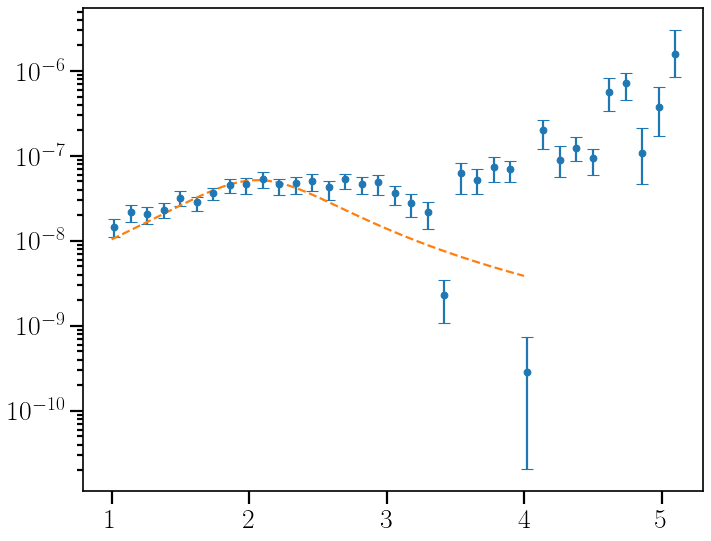

 FCN=89.3091 FROM HESSE     STATUS=OK             16 CALLS         119 TOTAL
                     EDM=3.86147e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Gamma_SR     1.16292e+00   1.00224e-01   5.66742e-05   1.38705e-03
   2  E_SR         2.13922e+00   3.93952e-02   2.90519e-05  -1.39551e-03
   3  sigma_SR     1.25337e+00   1.09833e-01   5.75716e-05   1.29585e-03


In [15]:
#START VALUES Pygmy scissors resonance
E_SR = 2.5 #Pygmy centroid (MeV) - this is from systematics (taken from TALYS)
Gamma_SR = 1.5 #Width (MeV)
sigma_SR = 1.0 #peak cross section (mb)
parameter_array_SR = np.asarray([Gamma_SR, E_SR, sigma_SR])

#Fitting the Scissors resonance
xmin_SR = 1
xmax_SR = 4
no_of_parameters_SR = 3
fit_strength_SR = TF1('fit_strength_SR', FitPygmy, xmin_SR, xmax_SR, no_of_parameters_SR)
fit_strength_SR.SetParameters(parameter_array_SR)
fit_strength_SR.SetParNames('Gamma_SR', 'E_SR', 'sigma_SR')
#fit_strength_SR.FixParameter(1, E_SR)
#fit_strength_SR.SetParLimits(0, 0.1, 10)
#fit_strength_SR.FixParameter(0, Gamma_SR)
OMPy_data.Fit(fit_strength_SR, 'RM+')



fig, ax = plt.subplots()
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='', label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')
#ax.errorbar(x=energy_gsf_ompy_reduced, y=gsf_ompy_median_reduced, yerr=gsf_ompy_error_reduced, marker='o', linestyle='', label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')

#plotting fit of Scissors Resonance
fitted_parameters_SR = np.zeros(3)
fitted_parameters_SR[0] = fit_strength_SR.GetParameter(0)
fitted_parameters_SR[1] = fit_strength_SR.GetParameter(1)
fitted_parameters_SR[2] = fit_strength_SR.GetParameter(2)
x_plot_SR = [np.linspace(xmin_SR, xmax_SR, 100)]
y_plot_SR = FitPygmy(x_plot_SR, fitted_parameters_SR)
ax.plot(x_plot_SR[0], y_plot_SR, '--', label="Scissors Resonance")

ax.set_yscale('log')
fig.show()


In [16]:
#getting fitted parameters for final fit
Gamma_r_GLo1 = fit_strength_E1.GetParameter(0)
E_r_GLo1 = fit_strength_E1.GetParameter(1)
sigma_r_GLo1 = fit_strength_E1.GetParameter(2)

Gamma_r_GLo2 = fit_strength_E1.GetParameter(3)
E_r_GLo2 = fit_strength_E1.GetParameter(4)
sigma_r_GLo2 = fit_strength_E1.GetParameter(5)

T_f = fit_strength_E1.GetParameter(6)

Gamma_pyg2 = fit_strength_M1.GetParameter(0)
E_pyg2 = fit_strength_M1.GetParameter(1)
sigma_pyg2 = fit_strength_M1.GetParameter(2)

Gamma_pyg2 = -3.75786e+00
E_pyg2 = 7.58556e+00
sigma_pyg2 = 1.43054e+01

Gamma_SR = fit_strength_SR.GetParameter(0)
E_SR = fit_strength_SR.GetParameter(1)
sigma_SR = fit_strength_SR.GetParameter(2)

Gamma_pyg1 = fit_strength_pyg1.GetParameter(0)
E_pyg1 = fit_strength_pyg1.GetParameter(1)
sigma_pyg1 = fit_strength_pyg1.GetParameter(2)

xmin_tot = 1.1
xmax_tot = 18.
no_of_parameters_tot = 16
fit_strength = TF1('fit_strength', FitFunctionStrength, xmin_tot, xmax_tot, no_of_parameters_tot)
parameter_array_full = np.asarray([Gamma_r_GLo1, E_r_GLo1, sigma_r_GLo1,
                                  Gamma_r_GLo2, E_r_GLo2, sigma_r_GLo2, T_f,
                                  Gamma_pyg1, E_pyg1, sigma_pyg1,
                                  Gamma_pyg2, E_pyg2, sigma_pyg2,
                                  Gamma_SR, E_SR, sigma_SR])

fit_strength.SetParameters(parameter_array_full)
fit_strength.SetParNames('Gamma_GLo1', 'E_GLo1', 'sigma_GLo1',
                        'Gamma_GLo2', 'E_GLo2', 'sigma_GLo2', 'T_f',
                            'Gamma_pyg1', 'E_pyg1', 'sigma_pyg1',
                            'Gamma_pyg2') #Only able to set 11 parameter names at once...
fit_strength.SetParName(11, 'E_pyg2')
fit_strength.SetParName(12, 'sigma_pyg2')
fit_strength.SetParName(13, 'Gamma_SR')
fit_strength.SetParName(14, 'E_SR')
fit_strength.SetParName(15, 'sigma_SR')

#fix E1 parameters
fit_strength.FixParameter(0, Gamma_r_GLo1)
fit_strength.FixParameter(1, E_r_GLo1)
fit_strength.FixParameter(2, sigma_r_GLo1)
fit_strength.FixParameter(3, Gamma_r_GLo2)
fit_strength.FixParameter(4, E_r_GLo2)
fit_strength.FixParameter(5, sigma_r_GLo2)
fit_strength.SetParLimits(6, 0, 100)

#fix/limit pyg1 parameters
fit_strength.FixParameter(7, Gamma_pyg1)
fit_strength.FixParameter(8, E_pyg1)
#fit_strength.FixParameter(9, sigma_pyg1)
fit_strength.SetParLimits(9, 0.1, 100)
#fit_strength.SetParLimits(8, 3, 5)

#fix/limit pyg2 parameters
fit_strength.FixParameter(11, E_pyg2)
fit_strength.FixParameter(10, Gamma_pyg2)
#fit_strength.SetParLimits(10, 0, )
fit_strength.FixParameter(12, sigma_pyg2)
#fit_strength.SetParLimits(12, 0, 100)

#fix/limit SR parameters
#fit_strength.FixParameter(13, Gamma_SR)
#fit_strength.SetParLimits(13, 1.0, 1.2)
#fit_strength.FixParameter(14, E_SR)
#fit_strength.FixParameter(15, sigma_SR)
fit_strength.SetParLimits(15, 0.1, 100)


#Defining all data (Berman and OmPy)
OmPy_and_GDR_data = TMultiGraph()
OmPy_and_GDR_data.Add(berman_233_gdrexp, "P")
OmPy_and_GDR_data.Add(gsf_ompy, "P")
OmPy_and_GDR_data.Fit(fit_strength, 'S')

 FCN=27564.6 FROM MIGRAD    STATUS=CONVERGED     629 CALLS         630 TOTAL
                     EDM=5.08933e-05    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.9 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Gamma_GLo1   3.00263e+00     fixed    
   2  E_GLo1       1.13334e+01     fixed    
   3  sigma_GLo1   3.05361e+02     fixed    
   4  Gamma_GLo2   3.50471e+00     fixed    
   5  E_GLo2       1.37140e+01     fixed    
   6  sigma_GLo2   3.15135e+02     fixed    
   7  T_f          1.64902e-07   6.16287e+01   0.00000e+00** at limit **
   8  Gamma_pyg1   9.76196e-04     fixed    
   9  E_pyg1       4.55485e+00     fixed    
  10  sigma_pyg1   1.00026e-01   8.65177e+01   0.00000e+00   5.86058e-04
  11  Gamma_pyg2  -3.75786e+00     fixed    
  12  E_pyg2       7.58556e+00     fixed    
  13  sigma_pyg2   1.43054e+01     fixed    
  14  Gamma_SR     2.13148e-04   1.00296e+00 

Info in <ROOT::Math::ParameterSettings>: lower/upper bounds outside current parameter value. The value will be set to (low+up)/2 


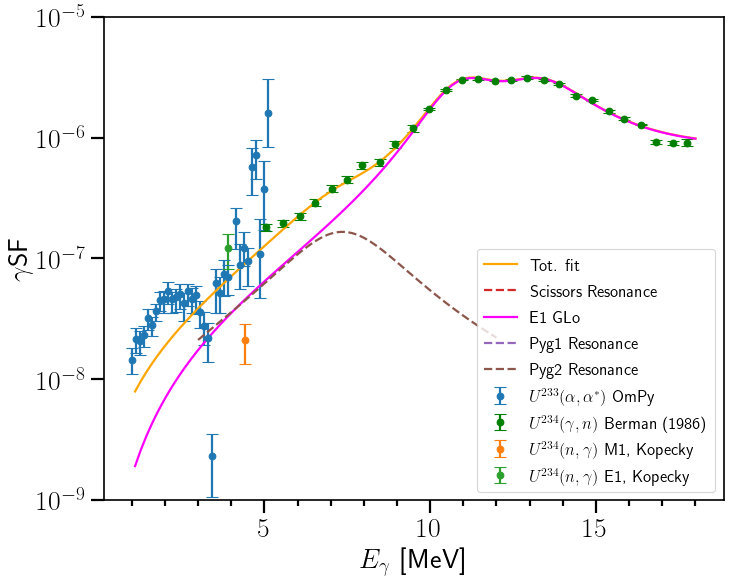

In [17]:
fig, ax = plt.subplots()

#This experiment
ax.errorbar(x=energy_gsf_ompy, y=gsf_ompy_median, yerr=gsf_ompy_error, marker='o', linestyle='', label='$U^{233}(\\alpha,\\alpha^*)$ OmPy')

#Experimental: Berman 1986
ax.errorbar(energy_exp1, gsf_exp1, yerr=gsf_exp1_error, x_err=None, fmt="o", color='green', label="$U^{234}(\gamma,n)$ Berman (1986)")

#Experimental: Kopecky
ax.errorbar(x=fMene, y=fMx, yerr=fMerr, xerr=None, fmt='o', label="$U^{234}(n,\gamma)$ M1, Kopecky")
ax.errorbar(x=fEene, y=fEx, yerr=fEerr, xerr=None, fmt='o', label="$U^{234}(n,\gamma)$ E1, Kopecky")

#Plotting total fit
fitted_parameters = np.zeros(no_of_parameters_tot)
for i in range(no_of_parameters_tot):
    fitted_parameters[i] = fit_strength.GetParameters()[i]
x_plot = [np.linspace(xmin_tot, xmax_tot, 100)]
y_plot = FitFunctionStrength(x_plot, fitted_parameters)
ax.plot(x_plot[0], y_plot, color='orange', label='Tot. fit')


#plotting fit of Scissors Resonance
fitted_parameters_SR = np.zeros(3)
fitted_parameters_SR[0] = fitted_parameters[13]
fitted_parameters_SR[1] = fitted_parameters[14]
fitted_parameters_SR[2] = fitted_parameters[15]
x_plot_SR = [np.linspace(xmin_SR, xmax_SR, 100)]
y_plot_SR = FitPygmy(x_plot_SR, fitted_parameters_SR)
ax.plot(x_plot_SR[0], y_plot_SR, '--', label="Scissors Resonance")

#Plotting fit of GDR
fitted_parameters_E1 = np.zeros(no_of_parameters_GDR)
for i in range(no_of_parameters_GDR):
    fitted_parameters_E1[i] = fit_strength_E1.GetParameters()[i]
x_plot_E1 = [np.linspace(xmin_GDR, xmax_GDR, 100)]
x_plot_E1 = [np.linspace(1.1, 18, 100)]
y_plot_E1 = FitFunctionE1(x_plot_E1, fitted_parameters_E1)
ax.plot(x_plot_E1[0], y_plot_E1, color='magenta', label='E1 GLo')

#plotting fit of Pyg1
no_of_parameters_pyg1 = 3
fitted_parameters_pyg1 = np.zeros(no_of_parameters_pyg1)
fitted_parameters_pyg1[0] = fitted_parameters[7]
fitted_parameters_pyg1[1] = fitted_parameters[8]
fitted_parameters_pyg1[2] = fitted_parameters[9]
x_plot_pyg1 = [np.linspace(xmin_pyg1, xmax_pyg1, 100)]
y_plot_pyg1 = FitPygmy(x_plot_pyg1, fitted_parameters_pyg1)
ax.plot(x_plot_pyg1[0], y_plot_pyg1, '--', label='Pyg1 Resonance')

#plotting fit of Pyg2
fitted_parameters_pyg2 = np.zeros(no_of_parameters_pyg2)
fitted_parameters_pyg2[0] = fitted_parameters[10]
fitted_parameters_pyg2[1] = fitted_parameters[11]
fitted_parameters_pyg2[2] = fitted_parameters[12]
x_plot_pyg2 = [np.linspace(xmin_pyg2, xmax_pyg2, 100)]
y_plot_pyg2 = FitPygmy(x_plot_pyg2, fitted_parameters_pyg2)
ax.plot(x_plot_pyg2[0], y_plot_pyg2, '--', label='Pyg2 Resonance')



ax.set_ylim(1e-9, 1e-5)
#ax.set_xlim(0, 7)
ax.set_yscale('log')
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel('$E_\gamma$  [MeV]')
ax.set_ylabel('$\gamma$SF')
ax.legend(fontsize=15)

fig.show()